In [1]:
! pip install joblib

    100% |████████████████████████████████| 286kB 14.9MB/s 
fastai 1.0.52 requires nvidia-ml-py3, which is not installed.
thinc 6.12.1 has requirement msgpack<0.6.0,>=0.5.6, but you'll have msgpack 0.6.0 which is incompatible.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import pdb
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import torch
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as functional

import importlib
import nhanes as nhanes
importlib.reload(nhanes)


%matplotlib notebook
%matplotlib inline

print(nhanes)

<module 'nhanes' from '/home/ec2-user/SageMaker/nhanes.py'>


In [3]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [4]:
# DATA_PATH = '/home/orpgol/OpportunisticLearning/CDC/NHANES/'
DATA_PATH = 'CDC/NHANES/'
DATASET = 'arthritis'

In [5]:
importlib.reload(nhanes)
ds = nhanes.Dataset(DATA_PATH)
ds.load_arthritis()
n_fe = ds.features.shape[1]
n_classes = 2

indx = np.argwhere(ds.targets != 3)
dataset_features = ds.features[indx.flatten()]
dataset_targets = ds.targets[indx.flatten()]

print('---')
print((dataset_features.shape))
print((dataset_targets.shape))

--------------------------------------------------
Processing: IMQ_H.XPT(92062, 199)
---
(49454, 199)
(49454,)


In [6]:
importlib.reload(nhanes)
perm = np.random.permutation(dataset_targets.shape[0])
dataset_features = dataset_features[perm]
dataset_targets = dataset_targets[perm]

def get_batch(n_size, phase):
    # select indices
    n_samples = dataset_features.shape[0]
    n_classes = int(dataset_targets.max() + 1)
    if phase == 'test':
        inds_sel = np.arange(0, int(n_samples*0.15), 1)
    elif phase == 'validation':
        n_samples = dataset_features.shape[0]
        inds_sel = np.arange(int(n_samples*0.15), int(n_samples*0.30), 1)
    elif phase == 'train':
        n_samples = dataset_features.shape[0]
        inds_sel = np.arange(int(n_samples*0.30), n_samples, 1)
    else:
        raise NotImplementedError
    inds_sel = np.random.permutation(inds_sel)
    batch_inds = []
    for cl in range(n_classes):
        inds_cl = inds_sel[dataset_targets[inds_sel] == cl]
        batch_inds.extend(inds_cl[:n_size//n_classes])
    batch_inds = np.random.permutation(batch_inds)
    
    return dataset_features[batch_inds], dataset_targets[batch_inds]
    
features_trn, targets_trn = get_batch(n_size=20000, phase='train')
features_tst, targets_tst = get_batch(n_size=10000, phase='test')

In [7]:
features_trn = torch.Tensor(features_trn)
targets_trn = torch.Tensor(targets_trn)
features_tst = torch.Tensor(features_tst)
targets_tst = torch.Tensor(targets_tst)

print(features_trn.shape)
print(torch.sum(targets_trn))

# print(features_trn.shape)
# print(targets_trn.shape)
# print(features_tst.shape)
# print(targets_tst.shape)

trn_means = features_trn.mean(dim=0)
trn_stds = features_trn.std(dim=0)

# transform = torchvision.transforms.Normalize(trn_means,trn_stds)
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize(trn_means, trn_stds)])

# # features_trn = torch.FloatTensor(1, features_trn.shape[0], features_trn.shape[1])
# features_trn = features_trn.unsqueeze(dim=0)
# features_tst = features_tst.unsqueeze(dim=0)
# features_trn = functional.to_pil_image(features_trn)
# features_tst = functional.to_pil_image(features_tst)

# features_trn = transform(features_trn)
# features_tst = transform(features_tst)

# features_trn = features_trn.squeeze(dim=0)
# features_tst = features_tst.squeeze(dim=0)

# print(features_trn[0])
# print(targets_trn[0])
# print(features_tst.shape)
# print(targets_tst.shape)


# print("0s")
# print((targets_trn == 0).sum())
# print("1's")
# print((targets_trn == 1).sum())
# print("---")
# print("0s")
# print((targets_tst == 0).sum())
# print("1's")
# print((targets_tst == 1).sum())


trainset = data_utils.TensorDataset(features_trn, targets_trn)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = data_utils.TensorDataset(features_tst, targets_tst)
# testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=True)

torch.Size([5000, 199])
tensor(2500.)


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # Defining 3 linear layers but NOT the way they should be connected
        self.fc1 = nn.Linear(199, 300)
        self.fc2 = nn.Linear(300, 400)
        self.fc3 = nn.Linear(400, 800)
        self.fc4 = nn.Linear(800, 300)
        self.fc5 = nn.Linear(300, 2)

    def forward(self, x): # tell how the layers are connected
        # Defining the way that the layers of the model should be connected
        # Performs RELU on the output of layer 'self.fc1'
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        # Passes the array through the last linear layer 'self.fc3'
        x = F.softmax(self.fc5(x), dim=1)
        return x


net = Net()

In [9]:
def choose_optim(option):
#     criterion = nn.MSELoss()
#     weight = torch.tensor([1,0])
#     criterion = nn.BCELoss(weight=weight)
    
    x = []

    def sgd_no_momentum():
        # SGD NO momentum
        print("SGD NO momentum")
        optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0, dampening=0, weight_decay=0, nesterov=False)
        optim = "SGD without momentum"
        x.append(optimizer)
        x.append(optim)

    def sgd_with_momentum():
        # SGD WITH momentum
        print("SGD WITH momentum")
        optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, dampening=0, weight_decay=0, nesterov=False)
        optim = "SGD with momentum"
        x.append(optimizer)
        x.append(optim)

    def adagrad():
        # Adagrad
        print("Adagrad")
        optimizer = torch.optim.Adagrad(net.parameters())
        optim = "Adagrad"
        x.append(optimizer)
        x.append(optim)

    def adam():
        # Adam
        print("Adam")
        optimizer = torch.optim.Adam(net.parameters())
        optim = "Adam"
        x.append(optimizer)
        x.append(optim)
        
    options = {
        0 : sgd_no_momentum,
        1 : sgd_with_momentum,
        2 : adagrad,
        3 : adam,
    }
    
    options[option]()
    return x

In [10]:
# def one_hot_v2(batch,depth):
#     ones = torch.sparse.torch.eye(depth)
#     return ones.index_select(0,batch)

In [11]:
q =[[0,1],[3,2],[6,5],[7,8]]
q = torch.tensor(q)
print(q.shape)
print(q)
q = q.max(dim=1)[0]
# q[q[0]<q[1]]=4
# print(q[:,0])
print(q)

torch.Size([4, 2])
tensor([[0, 1],
        [3, 2],
        [6, 5],
        [7, 8]])
tensor([1, 3, 6, 8])


In [12]:
def run_train():
    import time
    t = time.time()
    ff_time = 0
    bp_time = 0

    epoch_loss_list = []

    for epoch in range(200):  # loop over the dataset multiple times   
        epoch_loss = 0
        j = 0
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data      
#             labels = one_hot_v2(labels,10)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            ff_start = time.time()
            outputs = net(inputs)
            outputs_fix = outputs.max(dim=1)[0]
            
#             weights = (labels)*-99+100
# #             print(weights)
#             criterion.weight = weights
            
            loss = criterion(outputs_fix, labels)
            
            ff_elapsed = time.time() - ff_start
            ff_time += ff_elapsed
            
            bp_start = time.time()
            loss.backward()
            optimizer.step()
            bp_elapsed = time.time() - bp_start
            bp_time += bp_elapsed

            # print statistics
            running_loss += loss.item()
            if i % 50 == 49:    # print every 50 mini-batches
                print('[%d, %5d] loss: %.4f' %
                      (epoch + 1, i + 1, running_loss / 50))
                elapsed = time.time() - t
#                 print("Time: {0} seconds".format(elapsed))
                running_loss = 0.0

            epoch_loss += loss.item()
            j = i
        epoch_loss_list.append((epoch, epoch_loss/j))
#         print("EPOCH {0} LOSS: {1}".format(epoch_loss_list[-1][0], epoch_loss_list[-1][1]))
        epoch_loss = 0

    print('Finished Training')
    elapsed = time.time() - t
    print("Time: {0} seconds".format(elapsed))
    
    print("FF Time: {0} seconds".format(ff_time))
    print("BP Time: {0} seconds".format(bp_time))
    
    return epoch_loss_list

Adagrad
Finished Training
Time: 177.68823552131653 seconds
FF Time: 42.69845724105835 seconds
BP Time: 101.78816986083984 seconds
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,

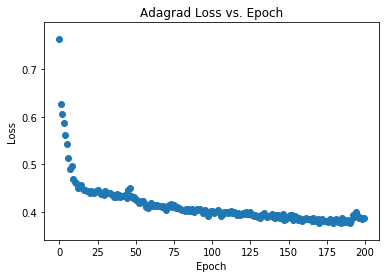

In [13]:
net = Net()
x = choose_optim(2)
# criterion = nn.MSELoss()
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(.006))
# criterion = nn.BCEWithLogitsLoss()
optimizer = x[0]
optim = x[1]
epoch_loss_list = run_train()

import matplotlib.pyplot as plt
# print(epoch_loss_list)
epoch_numbers, epoch_losses = zip(*epoch_loss_list)

print(epoch_numbers)
print(epoch_losses)
plt.scatter(epoch_numbers, epoch_losses)
plt.title(optim + ' ' + 'Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

tensor([1, 1, 1,  ..., 1, 0, 1])
              precision    recall  f1-score   support

           0       0.61      0.14      0.22       667
           1       0.62      0.94      0.75      1000

   micro avg       0.62      0.62      0.62      1667
   macro avg       0.61      0.54      0.49      1667
weighted avg       0.61      0.62      0.54      1667

Confusion matrix, without normalization
[[ 91 576]
 [ 59 941]]
Accuracy of the network on the test data: 61 %



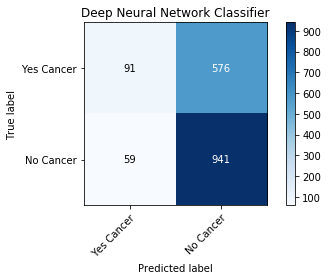

In [14]:
correct = 0
total = 0
zeroes = 0
ones = 0

with torch.no_grad():
    for data in testloader:
#         print('1')
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted*-1+1
        print(predicted)
        total += labels.size(0)
#         print(predicted)
        correct += (predicted == labels.long()).sum().item()
        zeroes += (predicted == 0).sum().item()
        ones += (predicted == 1).sum().item()     
        print(classification_report(labels.long(), predicted))
        example: plot_confusion_matrix(labels.long(),predicted,classes=['Yes Cancer', 'No Cancer'],title='Deep Neural Network Classifier')
        

print('Accuracy of the network on the test data: %d %%' % (100 * correct / total))

# print(zeroes)
# print(ones)

print()

In [ ]:
#AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

In [ ]:
net = Net()
x = choose_optim(1)
# criterion = nn.MSELoss()
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(.15))
# criterion = nn.BCEWithLogitsLoss()
optimizer = x[0]
optim = x[1]
epoch_loss_list = run_train()

import matplotlib.pyplot as plt
# print(epoch_loss_list)
epoch_numbers, epoch_losses = zip(*epoch_loss_list)

print(epoch_numbers)
print(epoch_losses)
plt.scatter(epoch_numbers, epoch_losses)
plt.title(optim + ' ' + 'Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

correct = 0
total = 0
zeroes = 0
ones = 0



In [ ]:
with torch.no_grad():
    for data in testloader:
#         print('1')
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted*-1+1
        print(predicted)
        total += labels.size(0)
#         print(predicted)
        correct += (predicted == labels.long()).sum().item()
        zeroes += (predicted == 0).sum().item()
        ones += (predicted == 1).sum().item()     
        print(classification_report(labels.long(), predicted))
        example: plot_confusion_matrix(labels.long(),predicted,classes=['Yes Cancer', 'No Cancer'],title='Deep Neural Network Classifier')
        

print('Accuracy of the network on the test data: %d %%' % (100 * correct / total))